# Cài đặt và import các thư viện cần thiết

In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1mwy4fo8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1mwy4fo8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
# Set-up SSIM Loss
!pip install pytorch-msssim

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import cv2
from datasets import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Chia dataset để training model

## Chia dataset cho tập train

In [5]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/train/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", train_images_np.shape)


Kích thước của mảng hình ảnh: (1177, 256, 256, 3)


In [6]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/train/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", train_labels_np.shape)

Kích thước của mảng mặt nạ: (1177, 256, 256)


In [7]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in train_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in train_labels_np],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(dataset_dict)

In [8]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1177
})

## Chia dataset cho tập validation

In [9]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/validation/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", val_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [10]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/validation/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", val_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [11]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in val_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in val_labels_np],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(dataset_dict)

In [12]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

## Chia dataset cho tập test

In [13]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/test/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", test_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [14]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/test/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", test_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [15]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in test_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in test_labels_np],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(dataset_dict)

In [16]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

# Kiểm tra ảnh và mặt nạ

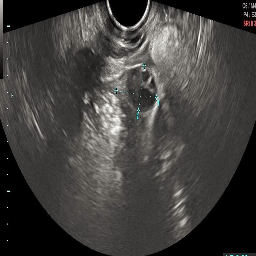

In [17]:
img_num = random.randint(0, train_images_np.shape[0]-1)
example = train_dataset[img_num]
image = example["image"]
image

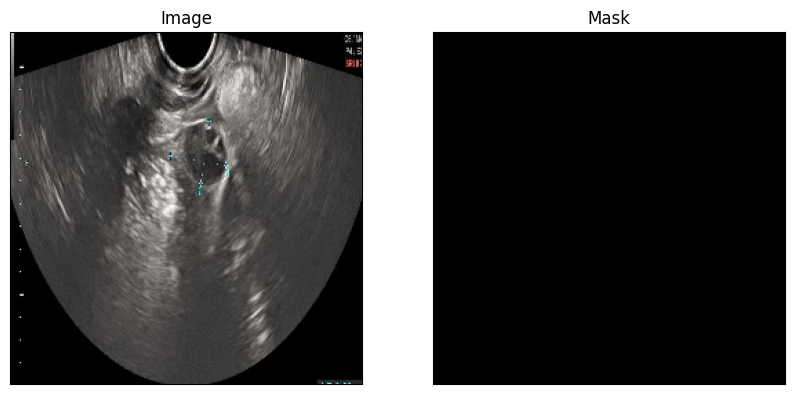

In [18]:
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

(-0.5, 255.5, 255.5, -0.5)

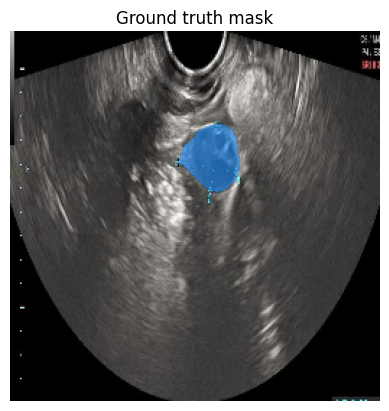

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Vẽ bounding boxes cho mặt nạ

In [20]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# Training Model

## Hàm tạo 1 dataset input images and mask

In [21]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt | vẽ box cho mặt nạ
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model | Chuẩn bị mặt nạ và hộp giới hạn
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default | Loại bỏ chiều Batch được thêm vào mặc định
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation | Thêm ground truth để đánh giá việc Segment sau này, đánh giá hiệu suất mô hình
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

## Load model SAM

### Xử lý dữ liệu để tương thích với đầu vào Model

In [22]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")

2024-04-24 10:41:23.364598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 10:41:23.364710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 10:41:23.516088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [23]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
test_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [24]:
example = train_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [25]:
example = val_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [26]:
example = test_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [27]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=False)

In [28]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [29]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [30]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [31]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load model Pretrained của Segment Anything

In [32]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("wanglab/medsam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Khởi tạo model với hàm tối ưu là Adam, hàm loss là DiceCELoss

In [33]:
import torch.optim as optim
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)

# Sử dụng DiceCELoss
diceCE_loss = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Sử dụng DiceFocalLoss
# diceFocal_loss = DiceFocalLoss(sigmoid=True, gamma=0.25)

# Sử dụng DiceLoss
# seg_loss = DiceLoss(to_onehot_y=True, softmax=True)



## Xây dựng Hàm Joint Loss

### Hàm Focal_Loss

In [34]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.

# pyre-strict

import torch
from torch.nn import functional as F


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

### Load hàm loss đánh giá model

In [35]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

smooth=1e-10
gamma = 2
weight = None

# Define functions for calculating evaluation metrics
def dice(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    false_positive = torch.sum(predicted) - true_positive
    return (2. * true_positive + smooth) / (2. *true_positive + false_negative + false_positive + smooth)

def iou(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    return (intersection + smooth) / (union + smooth)

def recall(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    return (true_positive + smooth) / (true_positive + false_negative + smooth)

def precision(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted) - true_positive
    return (true_positive + smooth) / (true_positive + false_positive + smooth)

def ssim(predicted, target):
    ssim_module = SSIM(data_range=255, size_average=True, channel=1)
    ssim_loss = 1 - ssim_module(predicted, target)
    return ssim_loss
    
def focalLoss(predicted, target):
    logpt = F.log_softmax(predicted, dim=1)
    pt = torch.exp(logpt)
    logpt = (1-pt)**gamma * logpt
    loss = F.nll_loss(logpt, target, weight)
    return loss

def jointLoss(predicted, target):
    loss = (1 - iou(predicted, target) + sigmoid_focal_loss(inputs = predicted, targets = target, alpha = 0.25, gamma = 2, reduction = "none",) + ssim(predicted, target))/3
    return loss

### Train Model

### Early Stopping

In [36]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint
checkpoint_dir = '/kaggle/working/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Add list to record loss of train dataset
train_loss_list = []
train_dice_loss = []
train_iou_loss = []
train_precision_loss = []
train_recall_loss = []

# Add list to record loss of validation dataset
val_loss_list = []
val_dice_loss = []
val_iou_loss = []
val_precision_loss = []
val_recall_loss = []

# Early stopping parameters
patience = 10  # Số lượng epochs mà mô hình không cải thiện trước khi dừng sớm
counter = 0

# Training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    
    # Train Model on Train Dataset
    epoch_losses = []
    train_dice_scores = []
    train_iou_scores = []
    train_recall_scores = []
    train_precision_scores = []
    
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device) 
        target = ground_truth_masks.unsqueeze(1)
        predicted_masks = torch.sigmoid(predicted_masks)
        loss = jointLoss(predicted_masks,target).mean()

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        predicted_masks_eval = (outputs.pred_masks.squeeze() > 0.5).float() 
        train_dice_scores.append(dice(predicted_masks_eval, ground_truth_masks))
        train_iou_scores.append(iou(predicted_masks_eval, ground_truth_masks))
        train_recall_scores.append(recall(predicted_masks_eval, ground_truth_masks))
        train_precision_scores.append(precision(predicted_masks_eval, ground_truth_masks))

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    if epoch == num_epochs - 1:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))
    else:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_final.pt'))

    # Tính loss trung bình và accuracy của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)
    train_loss_list.append(epoch_loss_mean)
    
    train_dice = torch.tensor(train_dice_scores).mean().item()
    train_iou = torch.tensor(train_iou_scores).mean().item()
    train_recall = torch.tensor(train_recall_scores).mean().item()
    train_precision = torch.tensor(train_precision_scores).mean().item()
    
    train_dice_loss.append(train_dice)
    train_iou_loss.append(train_iou)
    train_recall_loss.append(train_recall)
    train_precision_loss.append(train_precision)
    
    #-------------------------------------------------------------------------------------
    # Đánh giá mô hình trên tập validation
    validation_losses = []
    val_dice_scores = []
    val_iou_scores = []
    val_recall_scores = []
    val_precision_scores = []
    
    with torch.no_grad():  # Không tính gradient trong quá trình đánh giá
        for batch in tqdm(val_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device) 
            target = ground_truth_masks.unsqueeze(1)
            predicted_masks = torch.sigmoid(predicted_masks)
            loss = jointLoss(predicted_masks,target).mean()
            validation_losses.append(loss.item())

            predicted_masks_eval = (outputs.pred_masks.squeeze() > 0.5).float() 
            val_dice_scores.append(dice(predicted_masks_eval, ground_truth_masks))
            val_iou_scores.append(iou(predicted_masks_eval, ground_truth_masks))
            val_recall_scores.append(recall(predicted_masks_eval, ground_truth_masks))
            val_precision_scores.append(precision(predicted_masks_eval, ground_truth_masks))

    # Tính loss trung bình trên tập validation
    validation_loss_mean = mean(validation_losses)
    val_loss_list.append(validation_loss_mean)
     
    val_dice = torch.tensor(val_dice_scores).mean().item()
    val_iou = torch.tensor(val_iou_scores).mean().item()
    val_recall = torch.tensor(val_recall_scores).mean().item()
    val_precision = torch.tensor(val_precision_scores).mean().item()
    
    val_dice_loss.append(val_dice)
    val_iou_loss.append(val_iou)
    val_recall_loss.append(val_recall)
    val_precision_loss.append(val_precision)
    
    #-------------------------------------------------------------------------------------
    # In thông tin về epoch, loss của tập train và validation
    print(f'EPOCH: {epoch}')
    print(f'Train Mean loss: {epoch_loss_mean:.4f}')
    print(f'Train Dice: {train_dice:.4f}')
    print(f'Train IOU: {train_iou:.4f}')
    print(f'Train Recall: {train_recall:.4f}')
    print(f'Train Precision: {train_precision:.4f}')
    print('----------------------')
    print(f'Validation Mean loss: {validation_loss_mean:.4f}')
    print(f'Validation Dice: {val_dice:.4f}')
    print(f'Validation IOU: {val_iou:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation Precision: {val_precision:.4f}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if validation_loss_mean < best_loss:
    # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = validation_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, 'best_model_weights_MedSAM_jointLoss.pt'))
        print("Best model weights saved.")
    print('---------------------------------------------')
    
    #-------------------------------------------------------------------------------------
    # Kiểm tra early stopping
    if epoch > 0:  # Bắt đầu kiểm tra early stopping sau epoch đầu tiên
        if validation_loss_mean >= prev_epoch_loss:
            counter += 1
            if counter >= patience:
                print(f"Early stopping! No improvement in {patience} epochs.")
                break
        else:
            counter = 0  # Reset counter
            prev_epoch_loss = validation_loss_mean  # Lưu loss của epoch hiện tại để so sánh với epoch tiếp theo
    else:
        prev_epoch_loss = validation_loss_mean

100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 0
Train Mean loss: 0.1046
Train Dice: 0.8938
Train IOU: 0.8117
Train Recall: 0.8896
Train Precision: 0.9046
----------------------
Validation Mean loss: 0.0958
Validation Dice: 0.9093
Validation IOU: 0.8370
Validation Recall: 0.9243
Validation Precision: 0.8981
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 1
Train Mean loss: 0.0948
Train Dice: 0.9093
Train IOU: 0.8363
Train Recall: 0.9055
Train Precision: 0.9174
----------------------
Validation Mean loss: 0.0943
Validation Dice: 0.9105
Validation IOU: 0.8390
Validation Recall: 0.9173
Validation Precision: 0.9088
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 2
Train Mean loss: 0.0919
Train Dice: 0.9141
Train IOU: 0.8441
Train Recall: 0.9099
Train Precision: 0.9220
----------------------
Validation Mean loss: 0.0927
Validation Dice: 0.9123
Validation IOU: 0.8415
Validation Recall: 0.9006
Validation Precision: 0.9273
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 3
Train Mean loss: 0.0888
Train Dice: 0.9195
Train IOU: 0.8531
Train Recall: 0.9167
Train Precision: 0.9260
----------------------
Validation Mean loss: 0.0916
Validation Dice: 0.9145
Validation IOU: 0.8453
Validation Recall: 0.9167
Validation Precision: 0.9171
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 4
Train Mean loss: 0.0885
Train Dice: 0.9195
Train IOU: 0.8533
Train Recall: 0.9166
Train Precision: 0.9259
----------------------
Validation Mean loss: 0.0919
Validation Dice: 0.9136
Validation IOU: 0.8444
Validation Recall: 0.9184
Validation Precision: 0.9120
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 5
Train Mean loss: 0.0869
Train Dice: 0.9223
Train IOU: 0.8579
Train Recall: 0.9191
Train Precision: 0.9287
----------------------
Validation Mean loss: 0.0908
Validation Dice: 0.9140
Validation IOU: 0.8452
Validation Recall: 0.9039
Validation Precision: 0.9283
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 6
Train Mean loss: 0.0856
Train Dice: 0.9245
Train IOU: 0.8616
Train Recall: 0.9211
Train Precision: 0.9306
----------------------
Validation Mean loss: 0.0843
Validation Dice: 0.9264
Validation IOU: 0.8643
Validation Recall: 0.9100
Validation Precision: 0.9456
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 7
Train Mean loss: 0.0845
Train Dice: 0.9263
Train IOU: 0.8646
Train Recall: 0.9226
Train Precision: 0.9329
----------------------
Validation Mean loss: 0.0875
Validation Dice: 0.9200
Validation IOU: 0.8552
Validation Recall: 0.9128
Validation Precision: 0.9310
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 8
Train Mean loss: 0.0835
Train Dice: 0.9281
Train IOU: 0.8675
Train Recall: 0.9251
Train Precision: 0.9336
----------------------
Validation Mean loss: 0.0882
Validation Dice: 0.9196
Validation IOU: 0.8532
Validation Recall: 0.9107
Validation Precision: 0.9327
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 9
Train Mean loss: 0.0830
Train Dice: 0.9288
Train IOU: 0.8689
Train Recall: 0.9255
Train Precision: 0.9349
----------------------
Validation Mean loss: 0.0871
Validation Dice: 0.9213
Validation IOU: 0.8563
Validation Recall: 0.9141
Validation Precision: 0.9322
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 10
Train Mean loss: 0.0829
Train Dice: 0.9291
Train IOU: 0.8692
Train Recall: 0.9259
Train Precision: 0.9350
----------------------
Validation Mean loss: 0.0868
Validation Dice: 0.9220
Validation IOU: 0.8576
Validation Recall: 0.9154
Validation Precision: 0.9313
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


EPOCH: 11
Train Mean loss: 0.0813
Train Dice: 0.9319
Train IOU: 0.8739
Train Recall: 0.9289
Train Precision: 0.9374
----------------------
Validation Mean loss: 0.0865
Validation Dice: 0.9222
Validation IOU: 0.8577
Validation Recall: 0.9063
Validation Precision: 0.9417
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 12
Train Mean loss: 0.0812
Train Dice: 0.9319
Train IOU: 0.8741
Train Recall: 0.9283
Train Precision: 0.9378
----------------------
Validation Mean loss: 0.0888
Validation Dice: 0.9195
Validation IOU: 0.8536
Validation Recall: 0.9291
Validation Precision: 0.9136
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 13
Train Mean loss: 0.0815
Train Dice: 0.9313
Train IOU: 0.8731
Train Recall: 0.9290
Train Precision: 0.9359
----------------------
Validation Mean loss: 0.0876
Validation Dice: 0.9201
Validation IOU: 0.8542
Validation Recall: 0.9107
Validation Precision: 0.9334
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 14
Train Mean loss: 0.0804
Train Dice: 0.9332
Train IOU: 0.8764
Train Recall: 0.9310
Train Precision: 0.9377
----------------------
Validation Mean loss: 0.0884
Validation Dice: 0.9189
Validation IOU: 0.8531
Validation Recall: 0.9184
Validation Precision: 0.9241
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 15
Train Mean loss: 0.0796
Train Dice: 0.9345
Train IOU: 0.8785
Train Recall: 0.9312
Train Precision: 0.9402
----------------------
Validation Mean loss: 0.0862
Validation Dice: 0.9234
Validation IOU: 0.8599
Validation Recall: 0.9206
Validation Precision: 0.9297
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]

EPOCH: 16
Train Mean loss: 0.0795
Train Dice: 0.9347
Train IOU: 0.8788
Train Recall: 0.9320
Train Precision: 0.9395
----------------------
Validation Mean loss: 0.0851
Validation Dice: 0.9250
Validation IOU: 0.8630
Validation Recall: 0.9276
Validation Precision: 0.9256
---------------------------------------------
Early stopping! No improvement in 10 epochs.


In [37]:
train_loss_list

[0.10462527935897555,
 0.09483635572302321,
 0.09190796601549676,
 0.08878220125071463,
 0.08850949884397065,
 0.08690602093909713,
 0.08557586337744887,
 0.0845229599770342,
 0.08350772671844235,
 0.08299430201687108,
 0.08286110612173234,
 0.08125243280936785,
 0.08118448769499774,
 0.08151598034366485,
 0.08036002103106478,
 0.0796098480845449,
 0.07950117444091417]

In [38]:
train_dice_loss

[0.8937923908233643,
 0.9092929363250732,
 0.9140691161155701,
 0.9195416569709778,
 0.9194926619529724,
 0.9223189353942871,
 0.9245085120201111,
 0.9263284802436829,
 0.9281185269355774,
 0.9288276433944702,
 0.9290931224822998,
 0.931875467300415,
 0.931938886642456,
 0.9312903881072998,
 0.9332152009010315,
 0.9345493912696838,
 0.9346932172775269]

In [39]:
train_iou_loss

[0.8116961121559143,
 0.8362805843353271,
 0.8441303372383118,
 0.8530780076980591,
 0.8533172607421875,
 0.8579411506652832,
 0.8616430163383484,
 0.8645750284194946,
 0.8675061464309692,
 0.8689420223236084,
 0.8691946864128113,
 0.8739297389984131,
 0.8740822672843933,
 0.8730601668357849,
 0.8763515949249268,
 0.8784996271133423,
 0.8788154721260071]

In [40]:
train_recall_loss

[0.8896477222442627,
 0.9055010080337524,
 0.9098957180976868,
 0.9166665077209473,
 0.916638195514679,
 0.9191118478775024,
 0.9210895299911499,
 0.922590434551239,
 0.9250638484954834,
 0.9255056977272034,
 0.92586350440979,
 0.9289277195930481,
 0.9283110499382019,
 0.928999125957489,
 0.9309589862823486,
 0.9311990737915039,
 0.9320339560508728]

In [41]:
train_precision_loss

[0.9045839309692383,
 0.9173896908760071,
 0.9219988584518433,
 0.9259953498840332,
 0.9258515238761902,
 0.92868971824646,
 0.9306269884109497,
 0.9328951239585876,
 0.933594286441803,
 0.9348756670951843,
 0.9350008964538574,
 0.9373829960823059,
 0.9377790689468384,
 0.9358693361282349,
 0.937743604183197,
 0.9401699900627136,
 0.9395029544830322]

In [42]:
val_loss_list

[0.09581868809788194,
 0.09427761352837902,
 0.0926636920297799,
 0.09157042414562343,
 0.09193114737329418,
 0.09079216589054016,
 0.08425224291747563,
 0.08753745334401522,
 0.088202456599229,
 0.08707443466537619,
 0.08675813680029895,
 0.08654579601875723,
 0.08882621400160333,
 0.08764188185538331,
 0.08837513487837086,
 0.08624487946907135,
 0.08505314695712639]

In [43]:
val_dice_loss

[0.9092780351638794,
 0.9105196595191956,
 0.9123349189758301,
 0.9144958853721619,
 0.9136240482330322,
 0.9140322208404541,
 0.9264298677444458,
 0.9199848175048828,
 0.9195711612701416,
 0.9212837815284729,
 0.9219794273376465,
 0.9222091436386108,
 0.9195003509521484,
 0.9201396703720093,
 0.9189497828483582,
 0.9233880043029785,
 0.9249849915504456]

In [44]:
val_iou_loss

[0.8369609713554382,
 0.839013397693634,
 0.8414854407310486,
 0.8452507257461548,
 0.8444271087646484,
 0.8452191948890686,
 0.86429762840271,
 0.8551956415176392,
 0.8531532883644104,
 0.8562527298927307,
 0.857649028301239,
 0.8577085137367249,
 0.8535565733909607,
 0.8542017340660095,
 0.8531274199485779,
 0.8599051833152771,
 0.8630273342132568]

In [45]:
val_recall_loss

[0.9242694973945618,
 0.9173306822776794,
 0.9006158709526062,
 0.916742742061615,
 0.9184420108795166,
 0.9039319157600403,
 0.9099734425544739,
 0.912845253944397,
 0.9106829166412354,
 0.9140728712081909,
 0.915435254573822,
 0.9063469767570496,
 0.9290863275527954,
 0.9106765389442444,
 0.9184054136276245,
 0.9206089377403259,
 0.9275884628295898]

In [46]:
val_precision_loss

[0.8980668187141418,
 0.9087854623794556,
 0.9272556900978088,
 0.9170633554458618,
 0.9119663834571838,
 0.9283101558685303,
 0.9456047415733337,
 0.9310294389724731,
 0.9327302575111389,
 0.9322450160980225,
 0.9313126802444458,
 0.9416542649269104,
 0.9136195778846741,
 0.9333672523498535,
 0.9241170883178711,
 0.9297113418579102,
 0.9256214499473572]

# Draw chart for loss between train and validation dataset

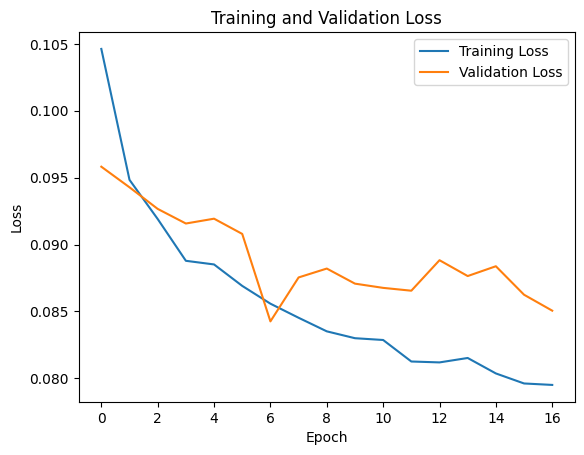

In [47]:
import matplotlib.pyplot as plt
import numpy as np

loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, train_loss_list, label='Training Loss')
plt.plot(loss, val_loss_list, label='Validation Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Draw chart for train dataset

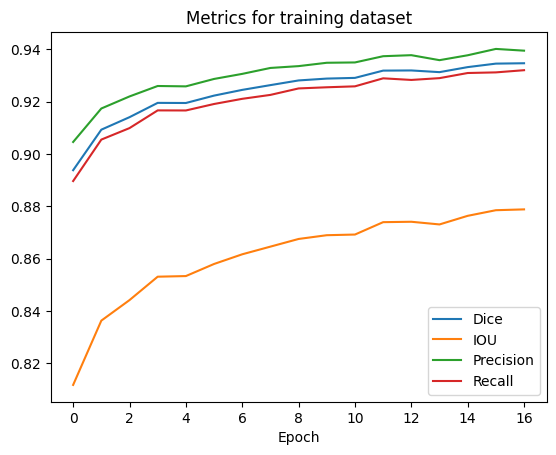

In [48]:
loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, train_dice_loss, label='Dice') 
plt.plot(loss, train_iou_loss, label='IOU') 
plt.plot(loss, train_precision_loss, label='Precision') 
plt.plot(loss, train_recall_loss, label='Recall') 
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics for training dataset')
plt.legend()
plt.show()


### Draw chart for validation dataset

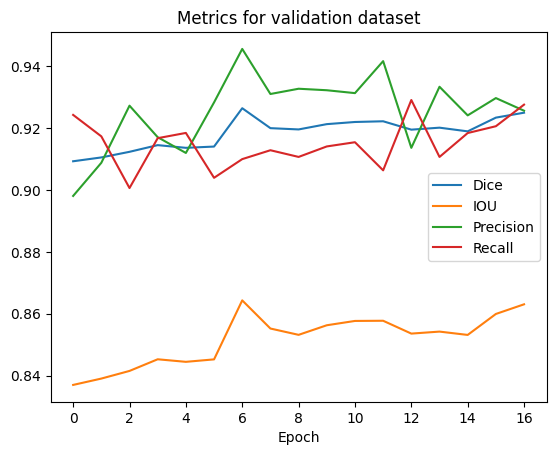

In [49]:
loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, val_dice_loss, label='Dice') 
plt.plot(loss, val_iou_loss, label='IOU') 
plt.plot(loss, val_precision_loss, label='Precision') 
plt.plot(loss, val_recall_loss, label='Recall') 
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics for validation dataset')
plt.legend()
plt.show()


### Đánh giá trọng số mô hình với tập Test Dataset (IOU, Precision, Recall, Dice)

In [50]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Tải trọng số từ checkpoint
checkpoint_path = "/kaggle/working/best_model_weights_MedSAM_jointLoss.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load trọng số vào mô hình
model.load_state_dict(checkpoint)

# Đặt mô hình vào chế độ đánh giá
model.eval()

# Tiếp tục quá trình kiểm tra mô hình như đã thực hiện trước đó
test_dice_scores = []
test_iou_scores = []
test_recall_scores = []
test_precision_scores = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute evaluation metrics
        predicted_masks = (torch.sigmoid(outputs['pred_masks']).squeeze() > 0.5).float()
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        test_dice_scores.append(dice(predicted_masks, ground_truth_masks))
        test_iou_scores.append(iou(predicted_masks, ground_truth_masks))
        test_recall_scores.append(recall(predicted_masks, ground_truth_masks))
        test_precision_scores.append(precision(predicted_masks, ground_truth_masks))

# Print evaluation metrics
print("\n")
print(f'Test Dice: {torch.tensor(test_dice_scores).mean().item():.4f}')
print(f'Test IOU: {torch.tensor(test_iou_scores).mean().item():.4f}')
print(f'Test Recall: {torch.tensor(test_recall_scores).mean().item():.4f}')
print(f'Test Precision: {torch.tensor(test_precision_scores).mean().item():.4f}')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/best_model_weights_MedSAM_jointLoss.pt'

### Train tiếp model từ trọng số

## Kiểm thử mô hình

In [ ]:
# import numpy as np
# from PIL import Image

# # let's take a random training example
# idx = 100

# # load image
# image = test_dataset[idx]["image"]
# image

In [ ]:
# import torch
# # Sử dụng GPU nếu có sẵn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # get box prompt based on ground truth segmentation map
# ground_truth_mask = np.array(test_dataset[idx]["label"])
# prompt = get_bounding_box(ground_truth_mask)

# # prepare image + box prompt for the model
# inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
# for k,v in inputs.items():
#   print(k,v.shape)

In [ ]:
# model.eval()

# # forward pass
# with torch.no_grad():
#   outputs = model(**inputs, multimask_output=False)

In [ ]:
# # apply sigmoid
# medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# # convert soft mask to hard mask
# medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
# medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [ ]:
# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)

In [ ]:
# import numpy as np
# from PIL import Image
# import torch
# import matplotlib.pyplot as plt

# # Sử dụng GPU nếu có sẵn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for idx in range(0, len(test_dataset)):  # Duyệt qua các chỉ số từ 1 đến 10
#     # load image
#     image = test_dataset[idx]["image"]

#     # get box prompt based on ground truth segmentation map
#     ground_truth_mask = np.array(test_dataset[idx]["label"])
#     prompt = get_bounding_box(ground_truth_mask)

#     # prepare image + box prompt for the model
#     inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

#     model.eval()

#     # forward pass
#     with torch.no_grad():
#         outputs = model(**inputs, multimask_output=False)

#     # apply sigmoid
#     medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
#     # convert soft mask to hard mask
#     medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
#     medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     # Hiển thị hình ảnh
#     axes[0].imshow(image)
#     axes[0].set_title("Image")
#     axes[0].axis("off")

#     # Hiển thị đồ thị cho ground truth mask
#     axes[1].imshow(ground_truth_mask)
#     axes[1].set_title("Ground truth mask")
#     axes[1].axis("off")

#     # Hiển thị đồ thị cho predicted mask
#     axes[2].imshow(medsam_seg)
#     axes[2].set_title("Predicted mask")
#     axes[2].axis("off")

#     plt.show()